#  Predição de Preços de Carros usando Modelos Ensemble: Random Forest
# 
###  Este modelo implementa um modelo Ramdon Forest para prever preços de carros.

### 1. Importação das Bibliotecas


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import joblib

### 2. Funções Auxiliares

In [3]:
def knn_input(df, n_neighbors=5):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

def remove_outliers_iqr(df, column):   
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1   
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR    
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

### 3. Carregamento e Pré-processamento dos Dados

In [4]:
train_path = '../data/raw/train.csv'
df = pd.read_csv(train_path)
df.drop(axis=1, columns=['id'], inplace=True)


In [5]:
df_input = knn_input(df, n_neighbors=25)


cat_cols_train = df_input.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)


df_input[cat_cols_train] = ordinal_encoder.fit_transform(df_input[cat_cols_train].astype(str))

In [6]:
df_input['engine_transmission'] = df_input['engine'] * df_input['transmission']

df_input['int_ext_color'] = df_input['int_col']*df_input['ext_col']

df_input.drop(columns = ['engine', 'transmission', 'int_col', 'ext_col'], inplace = True)

df_input['car_age'] = 2024 - df_input['model_year'] ## Adicionado em relação aos demais modelos

df_input.drop(axis=1, columns=['model_year'], inplace=True)

In [7]:
df_train_no_outliers = remove_outliers_iqr(df_input, 'milage')
df_train_no_outliers = remove_outliers_iqr(df_train_no_outliers, 'price')
df_train_no_outliers.reset_index(drop=True, inplace=True)
df = df_train_no_outliers

### 4. Preparação para Modelagem

In [8]:
seed = 42
y = df['price'] 
X = df.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [9]:
scaler = StandardScaler()
X_train.loc[:, ['brand','model', 'milage', 'int_ext_color', 'engine_transmission']] = scaler.fit_transform(X_train.loc[:, ['brand','model', 'milage', 'int_ext_color', 'engine_transmission']] )
X_test.loc[:, ['brand','model', 'milage', 'int_ext_color', 'engine_transmission']]  = scaler.transform(X_test.loc[:, ['brand','model', 'milage', 'int_ext_color', 'engine_transmission']] )

### 5. Treinamento e Avaliação do Modelo

In [10]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R²: {rf_r2:.2f}")

Random Forest RMSE: 13490.84
Random Forest R²: 0.60


### 6. Análise de Feature Importance

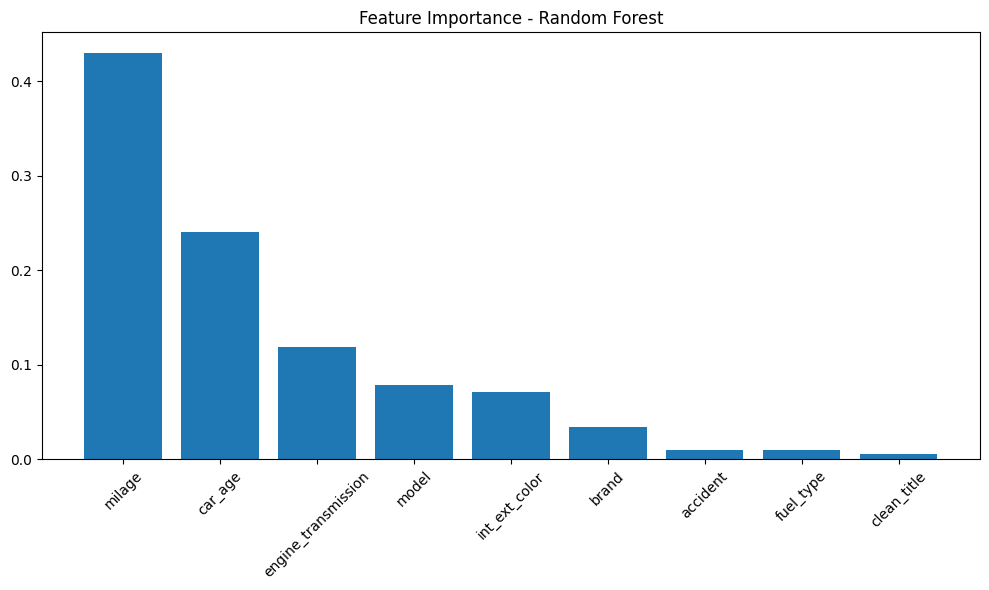

In [14]:
def plot_feature_importance(model, title):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    })
    importance_df = importance_df.sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['feature'], importance_df['importance'])
    plt.xticks(rotation=45)
    plt.title(f'Feature Importance - {title}')
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_model, 'Random Forest')